In [79]:
from mss import mss
import pydirectinput
import cv2
import numpy as np
import pytesseract
from matplotlib import pyplot as plt
import time
from gymnasium import Env  # Change this import
from gymnasium.spaces import Box, Discrete  # Change this import
from gymnasium.utils import env_checker  # Import the environment checker
from collections import deque

In [100]:
class WebGame(Env):
    def __init__(self, frame_stack=4, frame_skip=4):
        
        super().__init__()
        
        self.observation_space = Box(low=0, high=255, shape=(frame_stack,50,60), dtype=np.uint8)
        self.action_space = Discrete(3)
        
        self.cap = mss()
        self.game_location = {'top':400, 'left':-2200, 'width':600, 'height':300}
        self.done_location = {'top':200, 'left':-1830, 'width':1030, 'height':200}     
           # Frame stack parameter
        self.frame_stack = frame_stack
        self.frame_skip = frame_skip
        
        # Initialize frame buffer
        self.frames = deque(maxlen=frame_stack)
        
        # Initialize the frame stack with empty frames
        for _ in range(frame_stack):
            self.frames.append(np.zeros((83, 100), dtype=np.uint8))
             
    # What is called to do something in the game
    def step(self, action):
        # Action key - 0 = Space, 1 = Duck(down), 2 = No action (no op)
        action_map = {
            0:'space',
            1:'down',
            2:'no_op'
        }
        total_reward = 0
        # Skip frames by repeating the action for a number of steps
        for _ in range(self.frame_skip):
            # Perform the action
            if action != 2:
                pydirectinput.press(action_map[action])
        
        # Checking whether the game is done
            done, done_cap = self.get_done()
        # Reward - we get a point for every frame we are alive
            reward = 1
        
            if done:
                reward = -100
                break
        total_reward += reward
        # Determine if the game is over
        terminated = done  # Whether the game is successfully finished
        truncated = False  # Add logic here if you want to end the episode early
        # Get the next observation
        # new_observation = self.get_observation()
                # Get the new observation and update the frame stack
        new_frame = self.get_observation()[0, :, :]  # Remove channel dimension
        self.frames.append(new_frame)
        stacked_frames = np.stack(self.frames, axis=0)
        
        # Info dictionary
        info = {} # needed for stablebaselines what it expects
        
        return stacked_frames, total_reward, terminated, truncated, info
    
    def render(self):
        cv2.imshow('Game', np.array(self.cap.grab(self.game_location))[:,:,:3])
        if cv2.waitKey(1) & 0xFF == ord('q'):
            self.close()
    
    # Restart the game
    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        
        time.sleep(1)
        pydirectinput.click(x=-590, y=465)
        pydirectinput.press('space')
        # Reset frame stack with empty frames
        for _ in range(self.frame_stack):
            self.frames.append(np.zeros((50, 60), dtype=np.uint8))
        
        return np.stack(self.frames, axis=0), {}
        # return self.get_observation(), {}
    
    def close(self):
        cv2.destroyAllWindows()
    
    def get_observation(self):
        # Get screen capture of game
        raw = np.array(self.cap.grab(self.game_location))[:,:,:3]
        #Grayscale
        gray = cv2.cvtColor(raw, cv2.COLOR_BGR2GRAY)
        # Resize
        resized = cv2.resize(gray, (60,50))
        # Add channels first
        channel = np.reshape(resized, (1,50,60))
        return channel
    
    # Get the done text using OCR
    def get_done(self):
        # Get done screen
        done_cap = np.array(self.cap.grab(self.done_location))[:,:,:3]
        # Valid done text
        done_strings = ['GAME', 'GAHE']
        
        # Apply OCR
        done = False
        res = pytesseract.image_to_string(done_cap)[:4]
        if res == 'GAME':
            done = True
        return done, done_cap
    

In [101]:
env = WebGame()

In [5]:
import pydirectinput
import time

print("Move your mouse to the desired position and wait 5 seconds...")
time.sleep(5)
x, y = pydirectinput.position()
print(f"Mouse position: x={x}, y={y}")


Move your mouse to the desired position and wait 5 seconds...
Mouse position: x=-504, y=929


In [5]:
env.reset()

array([[[255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        ...,
        [255, 255, 255, ..., 255, 114,  33],
        [255, 255, 255, ..., 255, 255, 143],
        [255, 255, 255, ..., 255, 255, 255]]], dtype=uint8)

In [6]:
env.render()

In [7]:
env.close()

In [83]:
done, done_cap = env.get_done()
done

True

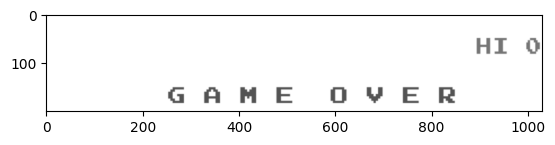

In [84]:
plt.imshow(done_cap)

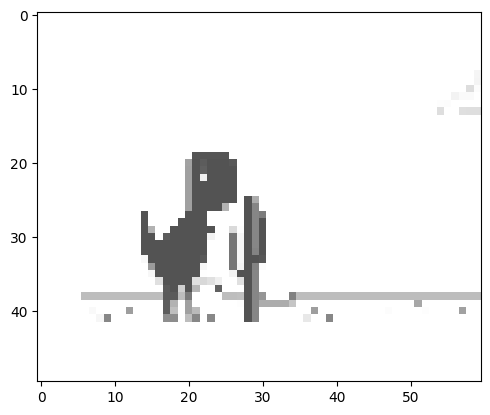

In [85]:
plt.imshow(cv2.cvtColor(env.get_observation()[0], cv2.COLOR_BGR2RGB))

In [49]:
# Play 10 games
for episode in range(10):
    obs = env.reset()
    done =False
    total_reward = 0
    
    while not done:
        obs, reward, done, info = env.step(env.action_space.sample())
        total_reward += reward
    print(f'Total Reward for episode {episode} is {total_reward}')

Total Reward for episode 0 is 13
Total Reward for episode 1 is 16
Total Reward for episode 2 is 13
Total Reward for episode 3 is 18
Total Reward for episode 4 is 37
Total Reward for episode 5 is 13
Total Reward for episode 6 is 13
Total Reward for episode 7 is 14
Total Reward for episode 8 is 13
Total Reward for episode 9 is 18


In [90]:
import os
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common import env_checker

In [102]:
env_checker.check_env(env)

In [103]:
class TrainAndLoggingCallback(BaseCallback):
    
    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path
        
    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)
            
    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)
            
        return True

In [104]:
CHECKPOINT_DIR = './train/'
LOG_DIR = './logs'

In [105]:
callback = TrainAndLoggingCallback(check_freq=1000, save_path=CHECKPOINT_DIR)

In [106]:
from stable_baselines3 import DQN


In [107]:
model = DQN('CnnPolicy', env, tensorboard_log=LOG_DIR, verbose=1, buffer_size=1200000, learning_starts=1000)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


c:\ProgramData\Anaconda3\CondaEnvs\.conda\dinoRL\lib\site-packages\stable_baselines3\common\buffers.py:241: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 28.82GB > 19.10GB
  warnings.warn(


In [108]:
model.learn(total_timesteps=5000, callback=callback)

Logging to ./logs\DQN_2
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.5      |
|    ep_rew_mean      | -97.5    |
|    exploration_rate | 0.973    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 0        |
|    time_elapsed     | 24       |
|    total_timesteps  | 14       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.62     |
|    ep_rew_mean      | -97.4    |
|    exploration_rate | 0.945    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 0        |
|    time_elapsed     | 48       |
|    total_timesteps  | 29       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.58     |
|    ep_rew_mean      | -97.4    |
|    exploration_rate | 0.918    |
| time/               |        

KeyboardInterrupt: 

In [74]:
model.load(os.path.join('train', 'best_model_5000'))

c:\ProgramData\Anaconda3\CondaEnvs\.conda\dinoRL\lib\site-packages\stable_baselines3\common\buffers.py:241: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 19.94GB > 13.69GB
  warnings.warn(


In [76]:
for episode in range(10):
    obs, _ = env.reset()
    done =False
    total_reward = 0
    
    while not done:
        action, _ = model.predict(obs)
        obs, reward, done, _, info = env.step(int(action))
        total_reward += reward
    print(f'Total Reward for episode {episode} is {total_reward}')
    time.sleep(2)

Total Reward for episode 0 is 12
Total Reward for episode 1 is 10


KeyboardInterrupt: 